In [1]:
import lzma
import json
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import subprocess
import numpy as np
sns.set_theme()

In [2]:
def load_output(filename):
    with lzma.open(filename, "r") as f:
        return json.load(f)

In [6]:
def scan_events(events):
    extra_data = {"lb_history": [], "ub_history": []}
    for e in events:
        t = e["type"]
        if t == "INITIAL_PHASE_DONE":
            extra_data["initial_phase_lb"] = e["lb"]
            extra_data["initial_phase_ub"] = e["ub"]
            extra_data["initial_phase_time"] = e["time"]
            extra_data["initial_num_interactions"] = e["num_interactions"]
            extra_data["reduced_num_interactions"] = e["num_interactions"]
        elif t == "FIRST_COLORING_DONE":
            extra_data["time_to_first_solution"] = e["time"]
        elif t == "DONE_IMPLIED_VERTEX_ELIMINATION":
            extra_data["reduced_num_interactions"] = e["reduced_size"]
        elif t in {"INITIAL_ITERATION_DONE","STRENGTHENED_CONSTRAINTS",} or "SOLVE_FULL_RELAX" in t:
            continue
        elif t == "LB_IMPROVED" or t == "IMPROVED_LB":
            source = None
            key = None
            if "lb" in e:
                key = "lb"
            else:
                key = "num_interactions"
            if "iteration" in e:
                source = "initial_phase"
            elif 'method' in e:
                source = e['method']
            elif 'source' in e:
                source = e['source']
            if source is None:
                raise RuntimeError("NO SOURCE FOR " + str(e))
            lb = e[key]
            if not extra_data["lb_history"] or extra_data["lb_history"][-1]["lb"] < lb:
                extra_data["lb_history"].append({"time": e["time"], "lb": lb, "source": source})
        elif t == "UB_IMPROVED" or t == "IMPROVED_UB" or t == "IMPROVED_SOLUTION":
            source = None
            key = "num_configs"
            if 'iteration' in e:
                source = "initial_phase"
            elif 'source' in e:
                source = e["source"]
            if key not in e:
                key = "ub"
            if key not in e:
                key = "size"
            if key not in e:
                raise RuntimeError("NO UB FOR "+str(e))
            if source is None:
                raise RuntimeError("NO SOURCE FOR " + str(e))
            extra_data["ub_history"].append({"time": e["time"], "ub": e[key], "source": source})
    return extra_data

In [7]:
def load_all_outputs():
    result = []
    for raw_file in os.listdir("02_output"):
        if not raw_file.endswith(".json.xz"):
            continue
        raw_data = load_output(os.path.join("02_output", raw_file))
        extra_data = scan_events(raw_data["events"])
        result.append({
            "instance_name": raw_file[:-12],
            "lb": raw_data["lb"],
            "ub": raw_data["ub"],
            "total_time": raw_data["events"][-1]["time"],
            "mes_size": len(raw_data["mutually_exclusive_set"]),
            **extra_data
        })
    return result

In [8]:
output = load_all_outputs()

In [9]:
output_df = pd.DataFrame(output)

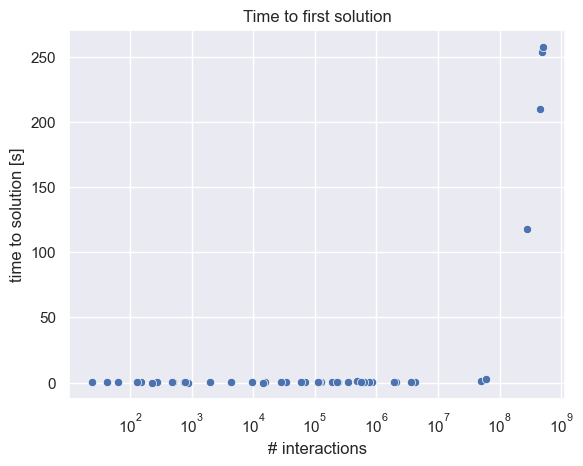

In [10]:
sns.scatterplot(data=output_df, x="initial_num_interactions", y="time_to_first_solution")
#sns.scatterplot(data=output_df, x="initial_num_interactions", y="initial_phase_time", label="Initial phase")
plt.gca().set_xlabel("# interactions")
plt.gca().set_ylabel("time to solution [s]")
plt.gca().set_xscale("log")
plt.gca().set_title("Time to first solution")
plt.savefig("time_to_first_solution.pdf")

In [11]:
excluded = [f"Automotive02_V{i}" for i in range(1, 5)] + ["Automotive01", "linux_2_6_28_6", "linux_2_6_33_3", "financial-services-2018-04-23"]
reduced_to_samplns_instances = output_df[~output_df["instance_name"].isin(excluded)]

In [12]:
samplns_best_lb = {
    'fiasco_2017-09-26_11-30-56': 225,
	'XSEngine': 32,
	'soletta_2017-03-09_21-02-40': 37,
	'APL': 7,
	'soletta_2015-06-26_18-38-56': 24,
	'fs_2017-05-22': 396,
	'atlas_mips32_4kc': 33,
	'axTLS': 10,
	'SortingLine': 9,
	'integrator_arm7': 33,
	'calculate': 5,
	'am31_sim': 29,
	'berkeleyDB1': 15,
	'financial_services': 4336,
	'PPU': 12,
	'toybox_2020-12-06_00-02-46': 8,
	'berkeleyDB2': 12,
	'aaed2000': 51,
	'BattleofTanks': 256,
	'FeatureIDE': 8,
	'ChatClient': 7,
	'uclibc_2020-12-24_11-54-53': 365,
	'APL-Model': 8,
	'eCos-3-0_i386pc': 36,
	'BankingSoftware': 29,
	'fiasco_2020-12-01_14-09-14': 196,
	'email': 6,
	'DMIE': 16,
	'E-Shop': 10,
	'uclibc_2008-06-05_13-46-47': 505,
	'busybox-1_18_0': 13,
	'ea2468': 32,
	'lcm': 6,
	'FreeBSD-8_0_0': 30,
	'FameDB': 8,
	'SafeBali': 11,
	'WaterlooGenerated': 82,
	'gpl': 16,
	'dell': 31,
	'toybox_2006-10-31_23-30-06': 8,
	'busybox_2020-12-16_21-53-05': 19,
	'Violet': 16,
	'car': 5,
	'TightVNC': 8,
	'EMBToolkit': 1872,
	'busybox-1_29_2': 21,
	'busybox_2007-01-24_09-14-09': 21
}
samplns_best_lb_df = pd.DataFrame([{"instance_name": k, "samplns_best_lb": v}
                                   for k,v in samplns_best_lb.items()])


In [13]:
reduced_to_samplns_instances = pd.DataFrame(reduced_to_samplns_instances)
reduced_to_samplns_instances.reset_index(inplace=True, drop=True)
reduced_to_samplns_instances = reduced_to_samplns_instances.merge(samplns_best_lb_df, left_on="instance_name", right_on="instance_name")
reduced_to_samplns_instances = pd.DataFrame(reduced_to_samplns_instances)
reduced_to_samplns_instances

,instance_name,lb,ub,total_time,mes_size,lb_history,ub_history,time_to_first_solution,initial_phase_lb,initial_phase_ub,initial_phase_time,initial_num_interactions,reduced_num_interactions,samplns_best_lb
0,fiasco_2017-09-26_11-30-56,225,225,6.247805,225,"[{'time': 0.073556085, 'lb': 106, 'source': 'i...","[{'time': 0.056655813, 'ub': 245, 'source': 'i...",0.055442,215,234,5.049522,59500,4830,225
1,XSEngine,34,34,457.359924,33,"[{'time': 0.150853502, 'lb': 13, 'source': 'in...","[{'time': 0.148054072, 'ub': 65, 'source': 'in...",0.147252,28,60,5.163649,762704,126866,32
2,soletta_2017-03-09_21-02-40,37,37,6.710493,37,"[{'time': 0.038662633, 'lb': 12, 'source': 'in...","[{'time': 0.036490633, 'ub': 58, 'source': 'in...",0.035795,35,53,5.039167,124634,20978,37
3,APL,7,7,5.082289,5,"[{'time': 0.022894996, 'lb': 2, 'source': 'ini...","[{'time': 0.022339035, 'ub': 9, 'source': 'ini...",0.021855,3,9,5.021870,273,164,7
4,soletta_2015-06-26_18-38-56,24,24,5.187797,23,"[{'time': 0.029200192, 'lb': 10, 'source': 'in...","[{'time': 0.028361059, 'ub': 31, 'source': 'in...",0.027848,22,27,5.028509,15242,6076,24
5,fs_2017-05-22,396,396,5.370952,396,"[{'time': 0.352272936, 'lb': 348, 'source': 'i...","[{'time': 0.240280317, 'ub': 404, 'source': 'i...",0.235509,394,396,5.268343,242091,402,396
6,atlas_mips32_4kc,34,34,945.218365,33,"[{'time': 0.148254735, 'lb': 12, 'source': 'in...","[{'time': 0.145903618, 'ub': 64, 'source': 'in...",0.145157,29,59,5.160852,676337,109005,33
7,axTLS,10,11,3600.017995,10,"[{'time': 0.034760474, 'lb': 3, 'source': 'ini...","[{'time': 0.034258502, 'ub': 16, 'source': 'in...",0.033783,9,13,5.034798,4349,2181,10
8,SortingLine,9,9,5.101767,8,"[{'time': 0.034510458, 'lb': 3, 'source': 'ini...","[{'time': 0.033913018, 'ub': 13, 'source': 'in...",0.033372,7,9,5.033488,843,272,9
9,integrator_arm7,34,34,1044.625189,33,"[{'time': 0.130744744, 'lb': 13, 'source': 'in...","[{'time': 0.128294576, 'ub': 61, 'source': 'in...",0.127326,30,59,5.130715,738076,118678,33


In [11]:
reduced_to_samplns_instances["initial_solution_gap"] = (reduced_to_samplns_instances["initial_phase_ub"] - reduced_to_samplns_instances["samplns_best_lb"]) / reduced_to_samplns_instances["samplns_best_lb"]
reduced_to_samplns_instances["initial_solution_gap_pct"] = reduced_to_samplns_instances["initial_solution_gap"] * 100.0
reduced_to_samplns_instances["initial_alg_name"] = "fast initial [47]"
reduced_to_samplns_instances["sammy_name"] = "sammy [47]"
reduced_to_samplns_instances["best_known_bound"] = np.maximum(reduced_to_samplns_instances["samplns_best_lb"], reduced_to_samplns_instances["lb"])
reduced_to_samplns_instances["sammy_gap"] = (reduced_to_samplns_instances["ub"] - reduced_to_samplns_instances["samplns_best_lb"]) / reduced_to_samplns_instances["samplns_best_lb"] 
reduced_to_samplns_instances["sammy_gap_pct"] = reduced_to_samplns_instances["sammy_gap"] * 100

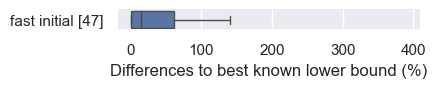

In [12]:
sns.catplot(data=reduced_to_samplns_instances, kind="box", x="initial_solution_gap_pct", errorbar="sd", y="initial_alg_name")
plt.gca().set_xlim(-20, 410)
plt.gcf().set_size_inches(4.5, 0.25)
plt.ylabel("")
plt.xlabel("Differences to best known lower bound (%)")
plt.savefig("initial_sol_qual_samplns_comparison.pdf", bbox_inches="tight")

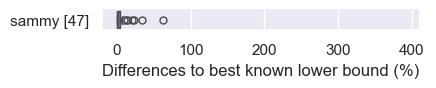

In [13]:
sns.catplot(data=reduced_to_samplns_instances, kind="box", x="sammy_gap_pct", y="sammy_name")
plt.gca().set_xlim(-20, 410)
plt.gcf().set_size_inches(4.5, 0.25)
plt.ylabel("")
plt.xlabel("Differences to best known lower bound (%)")
# we need to take care of the better LBs...
plt.savefig("sammy_sol_qual_broken_samplns_comparison.pdf", bbox_inches="tight")

In [14]:
output_df.sort_values("lb")

,instance_name,lb,ub,total_time,mes_size,lb_history,ub_history,time_to_first_solution,initial_phase_lb,initial_phase_ub,initial_phase_time,initial_num_interactions,reduced_num_interactions
13,calculate,5,5,5.050964,4,"[{'time': 0.025189609, 'lb': 2, 'source': 'ini...","[{'time': 0.024949768, 'ub': 5, 'source': 'ini...",0.024343,4,5,5.024355,43,14
49,car,5,5,5.062714,4,"[{'time': 0.036416897, 'lb': 4, 'source': 'ini...","[{'time': 0.035830176, 'ub': 5, 'source': 'ini...",0.035323,4,5,5.035380,24,5
37,lcm,6,6,5.062966,4,"[{'time': 0.037358378, 'lb': 4, 'source': 'ini...","[{'time': 0.036810778, 'ub': 6, 'source': 'ini...",0.036197,4,6,5.036251,42,16
30,email,6,6,5.073100,4,"[{'time': 0.018117581, 'lb': 2, 'source': 'ini...","[{'time': 0.017629999, 'ub': 7, 'source': 'ini...",0.016798,4,7,5.016895,64,33
24,ChatClient,7,7,5.754097,5,"[{'time': 0.015274808, 'lb': 2, 'source': 'ini...","[{'time': 0.015155986, 'ub': 11, 'source': 'in...",0.014587,4,8,5.014619,152,113
6,APL,7,7,5.082289,5,"[{'time': 0.022894996, 'lb': 2, 'source': 'ini...","[{'time': 0.022339035, 'ub': 9, 'source': 'ini...",0.021855,3,9,5.021870,273,164
23,FeatureIDE,8,8,18.579965,5,"[{'time': 0.032114531, 'lb': 2, 'source': 'ini...","[{'time': 0.031375809, 'ub': 17, 'source': 'in...",0.030821,3,10,5.030791,489,213
19,toybox_2020-12-06_00-02-46,8,13,3600.114895,7,"[{'time': 0.037718339, 'lb': 3, 'source': 'ini...","[{'time': 0.036822319, 'ub': 20, 'source': 'in...",0.036181,6,18,5.035023,186912,154083
40,FameDB,8,8,5.072015,6,"[{'time': 0.013469339, 'lb': 4, 'source': 'ini...","[{'time': 0.013039458, 'ub': 9, 'source': 'ini...",0.012488,5,9,5.012478,225,118
46,toybox_2006-10-31_23-30-06,8,8,5.583856,8,"[{'time': 0.031154032, 'lb': 3, 'source': 'ini...","[{'time': 0.030581491, 'ub': 13, 'source': 'in...",0.029964,6,11,5.029882,473,111


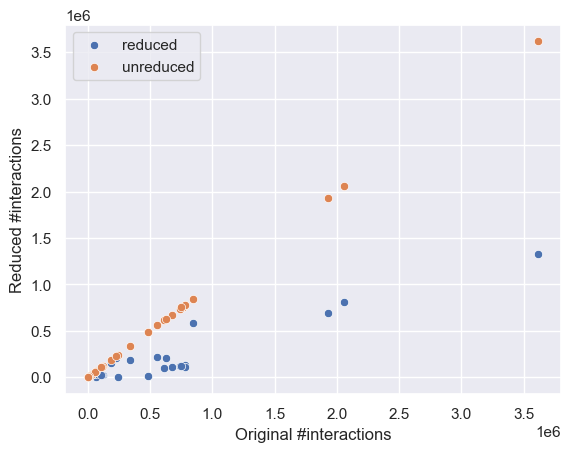

In [15]:
sns.scatterplot(data=reduced_to_samplns_instances, x="initial_num_interactions", y="reduced_num_interactions", label="reduced")
sns.scatterplot(data=reduced_to_samplns_instances, x="initial_num_interactions", y="initial_num_interactions", label="unreduced")
plt.gca().set_xlabel("Original #interactions")
plt.gca().set_ylabel("Reduced #interactions")
plt.savefig("interaction_reduction.pdf")

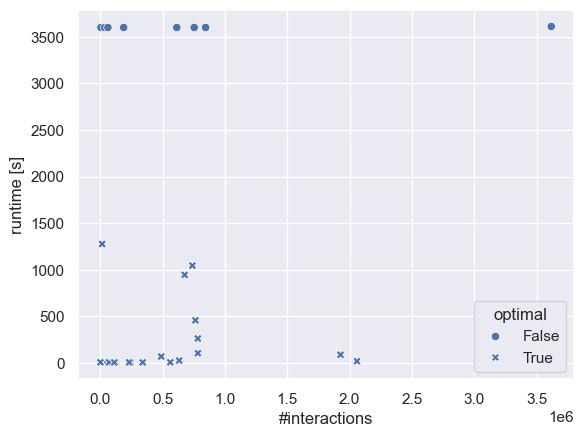

In [16]:
reduced_to_samplns_instances["optimal"] = reduced_to_samplns_instances["lb"] >= reduced_to_samplns_instances["ub"]
sns.scatterplot(data=reduced_to_samplns_instances, x="initial_num_interactions", y="total_time", style="optimal")
plt.gca().set_xlabel("#interactions")
plt.gca().set_ylabel("runtime [s]")
plt.savefig("time_to_optimality.pdf", bbox_inches="tight")